# Project 2
Identify a large 2-node network dataset—you can start with a dataset in a repository.
Your data should meet the criteria that it consists of ties between and not within two (or more) distinct groups.

Reduce the size of the network using a method such as the island method described in chapter 4 of social network analysis.
What can you infer about each of the distinct groups?

## Required Packages

In [1]:
import matplotlib.pyplot as plt
import networkx as nx
from networkx.algorithms import bipartite as bp
import numpy as np
import pandas as pd
import math
import plotly.graph_objects as go
import plotly.express as px
import yfinance as yf
import ssl

ssl._create_default_https_context = ssl._create_unverified_context

## About the Data

We will consider the yahoo finance module in python and it is a very easy module to work with.

The ticker Module, which allows access to data in pythonic way.

![Dow Jones Wiki]("https://simple.wikipedia.org/wiki/Dow_Jones_Industrial_Average" "Dow Jones Wiki")

## Capturing Data

In [2]:
# scraping company tickers and info
tickers_df = pd.read_html('https://en.wikipedia.org/wiki/Dow_Jones_Industrial_Average')[1]
tickers_df.head(5)

,Company,Exchange,Symbol,Industry,Date added,Notes,Index weighting
0,3M,NYSE,MMM,Conglomerate,1976-08-09,As Minnesota Mining and Manufacturing,3.02%
1,American Express,NYSE,AXP,Financial services,1982-08-30,NaN,3.60%
2,Amgen,NASDAQ,AMGN,Biopharmaceutical,2020-08-31,NaN,4.48%
3,Apple,NASDAQ,AAPL,Information technology,2015-03-19,NaN,3.25%
4,Boeing,NYSE,BA,Aerospace and defense,1987-03-12,NaN,3.96%


In [3]:
# extract symbol from df
# add them into a list
ticker_list = tickers_df.Symbol.to_list()

In [4]:
# create dictionary with the stored symbols as keys
ticker_dict = dict.fromkeys(ticker_list)

# loop through keys to create ticker class and store institutional holders df
for comp in ticker_dict:
    ticker = yf.Ticker(comp)
    inst_hol = ticker.institutional_holders
    inst_hol['Comp'] = comp
    ticker_dict[comp] = inst_hol

In [5]:
# create variable containing a list of all 30 companies of dow jones
all_dow = pd.concat(ticker_dict.values(), ignore_index=True)

#### Dow Jones Companies + Institutional Holders Ownership

In [6]:
all_dow

,Holder,Shares,Date Reported,% Out,Value,Comp
0,"Vanguard Group, Inc. (The)",50240763,2021-12-30,0.0880,8924266731,MMM
1,Blackrock Inc.,41810186,2021-12-30,0.0732,7426743339,MMM
2,State Street Corporation,30979936,2021-12-30,0.0542,5502966031,MMM
3,"Geode Capital Management, LLC",10780080,2021-12-30,0.0189,1914865610,MMM
4,"Charles Schwab Investment Management, Inc.",10557291,2021-12-30,0.0185,1875291600,MMM
...,...,...,...,...,...,...
295,Northern Trust Corporation,16607064,2021-12-30,0.0060,2402876090,WMT
296,Morgan Stanley,15580922,2021-12-30,0.0056,2254403604,WMT
297,Norges Bank Investment Management,15012238,2020-12-30,0.0054,2164014107,WMT
298,State Farm Mutual Automobile Insurance Co,13083050,2021-12-30,0.0047,1892986504,WMT


## Social Network

In [7]:
# create a graph
edges = [tuple(x) for x in all_dow[['Holder', 'Comp', 'Shares']].values.tolist()]

In [8]:
B = nx.Graph()
B.add_nodes_from(all_dow['Holder'].unique(), bipartite=0, label='holder',edge_attr=True)
B.add_nodes_from(all_dow['Comp'].unique(), bipartite=1, label='comp', edge_attr=True)

for row in edges:
    B.add_edge(row[0], row[1], shares=row[2])

In [9]:
edge_list = nx.to_edgelist(B)

In [10]:
nx.is_connected(B)

True

In [11]:
nx.is_bipartite(B)

True

### Node Manipulations

In [12]:
bottom_nodes, top_nodes = bp.sets(B)

In [13]:
top_nodes = {n for n, d in B.nodes(data=True) if d["bipartite"] == 0}
bottom_nodes = set(B) - top_nodes

print(list(top_nodes)[:5])
print(list(bottom_nodes)[:5])

['Dodge & Cox Inc', 'Northern Trust Corporation', 'Blackrock Inc.', 'ClearBridge Investments, LLC', 'Loomis Sayles & Company, LP']
['JPM', 'GS', 'MRK', 'AXP', 'BA']


In [14]:
color = bp.color(B)
color_dict = {0:'b', 1:'r'}
color_list = [color_dict[i[1]] for i in B.nodes.data('bipartite')]

In [15]:
pos = dict()
color = []
pos.update( (n, (1, i)) for i, n in enumerate(bottom_nodes) )
pos.update( (n, (2, i)) for i, n in enumerate(top_nodes) )

### First Look at Social Network Graph

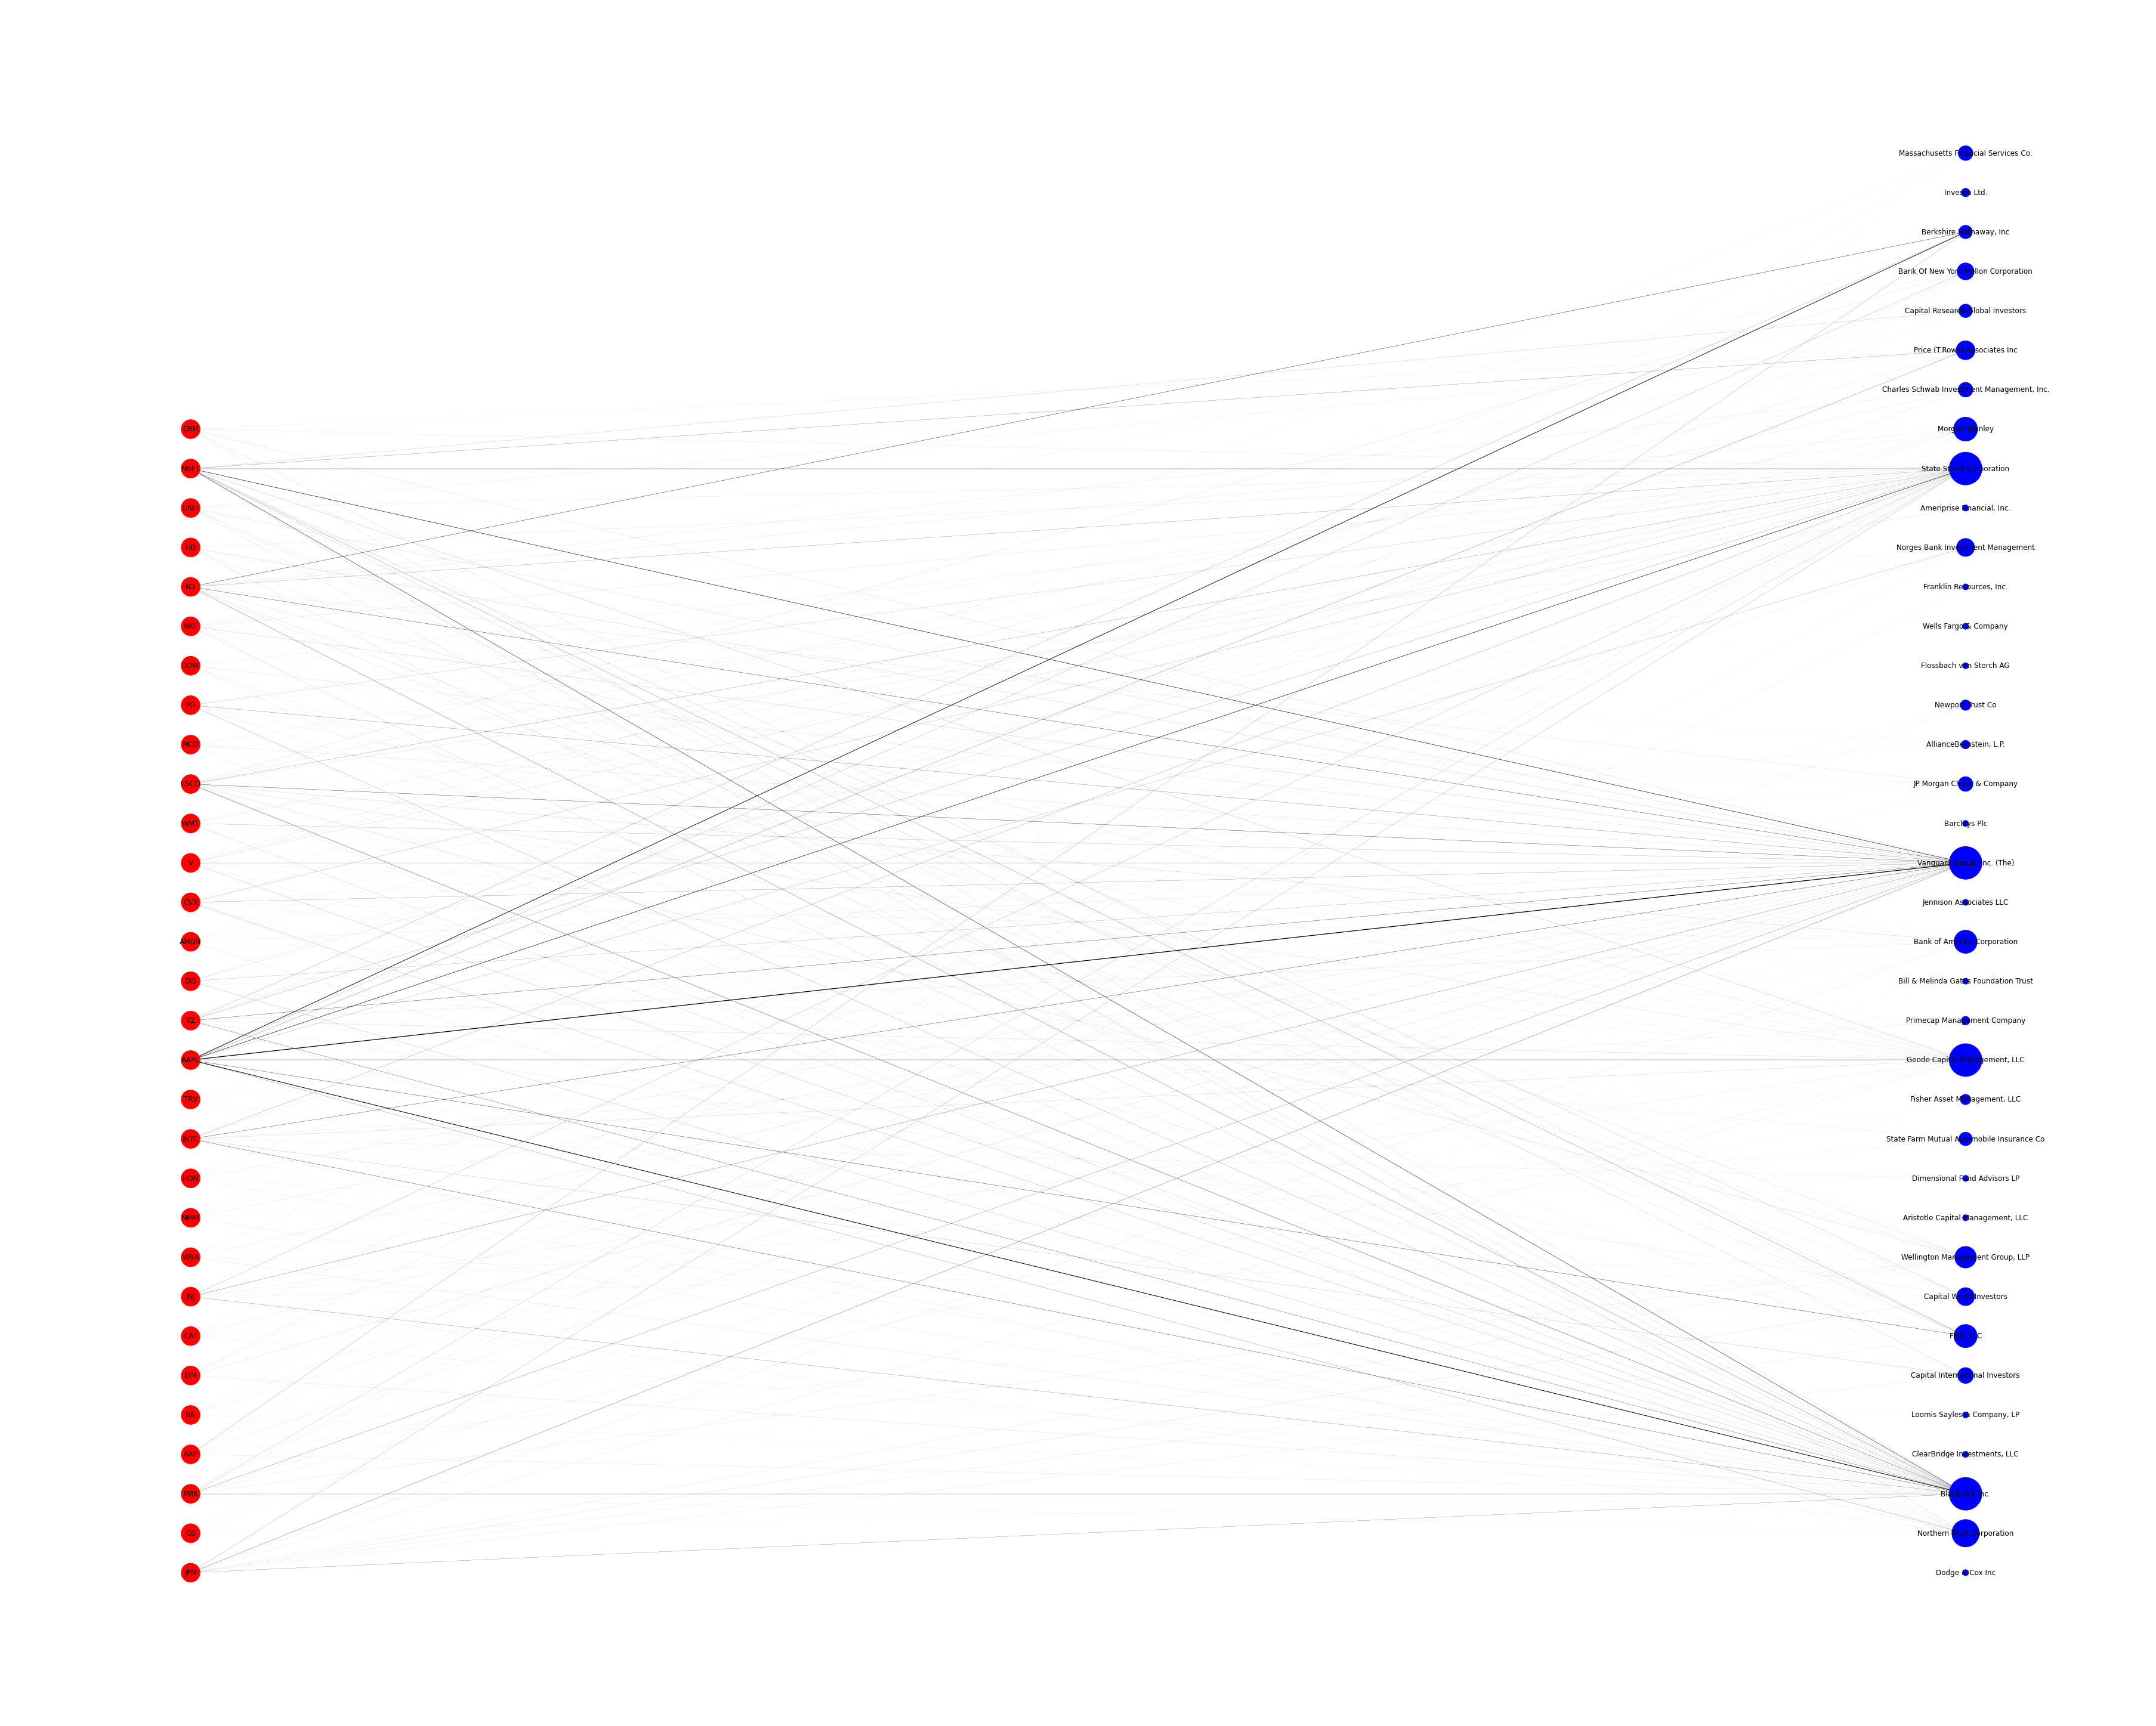

In [16]:
# hello dow jones network
plt.figure(figsize=(50,40))
nx.draw(B, pos=pos,
        with_labels=True,
        node_color = color_list,
        node_size = [v * 100 for v in dict(B.degree()).values()],
        width = [v[2]['shares']/1_000_000_000 for v in edge_list])
plt.show()

## Projected Bipartite Graph

### Stocks

In [17]:
S = bp.weighted_projected_graph(B, bottom_nodes, ratio = False)

s_list = {}

for s in bottom_nodes:
   s_list[s] = S.degree(s) 

stock_df = pd.DataFrame.from_dict(s_list, orient='index', columns=['Degree'])

print(stock_df.nlargest(5, 'Degree'))
print(stock_df.nsmallest(5, 'Degree'))

     Degree
JPM      29
GS       29
MRK      29
AXP      29
BA       29
     Degree
JPM      29
GS       29
MRK      29
AXP      29
BA       29


### Institutional Holders

In [18]:
H = bp.weighted_projected_graph(B, top_nodes, ratio = False)

h_list = {}

for h in top_nodes:
   h_list[h] = H.degree(h) 

holder_df = pd.DataFrame.from_dict(h_list, orient='index', columns=['Degree'])

print(holder_df.nlargest(5, 'Degree'))
print(holder_df.nsmallest(5, 'Degree'))

                               Degree
Blackrock Inc.                     36
Geode Capital Management, LLC      36
Vanguard Group, Inc. (The)         36
State Street Corporation           36
Northern Trust Corporation         32
                                   Degree
Dodge & Cox Inc                         9
ClearBridge Investments, LLC            9
Loomis Sayles & Company, LP             9
Aristotle Capital Management, LLC       9
Dimensional Fund Advisors LP            9


In [22]:
fig = px.histogram(holder_df, x = 'Degree', nbins = 10)
fig.update_layout(title = 'Histogram of Degree')
fig.show()

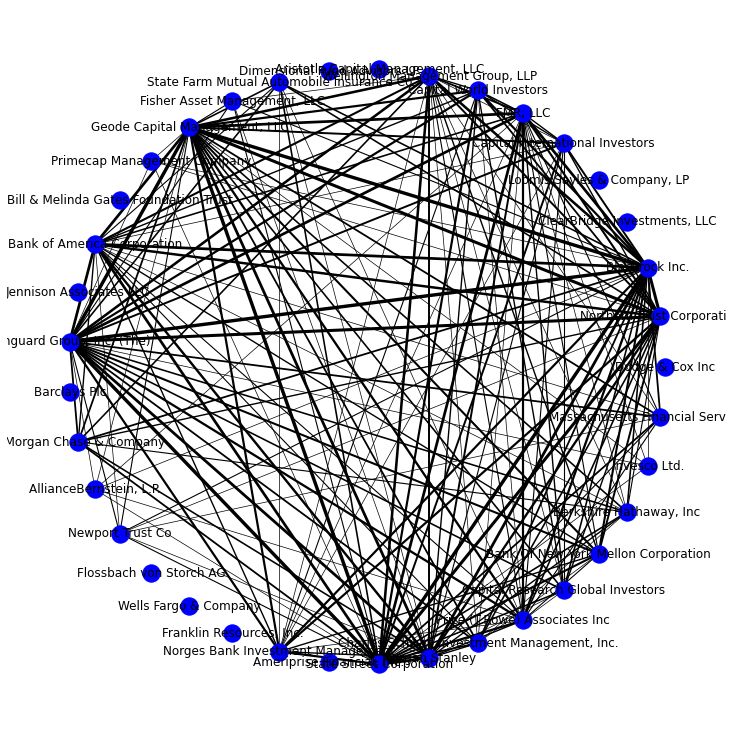

In [39]:
weights = [math.log(edata['weight']) for f,t,edata in H.edges(data=True)]

plt.figure(figsize=(10,10))
nx.draw_circular(H,width=weights, node_color='blue', with_labels=True)

In [40]:
# threshold of 1.5 accounts for 80% 
fig = go.Figure(data=[go.Histogram(x=weights, cumulative_enabled=True)])
fig.update_layout(title = 'Cumulative Histogram of Insitutional Holders\' Weight')

fig.show()

### Islands in the Net

Using the island method on weights.

In [36]:
def trim_edges(g, weight=1):
    g2=nx.Graph()
    for f, to, edata in g.edges(data=True):
        if edata['weight'] > weight:
            w = edata['weight']
            g2.add_edge(f,to,weighth=w)
    return g2

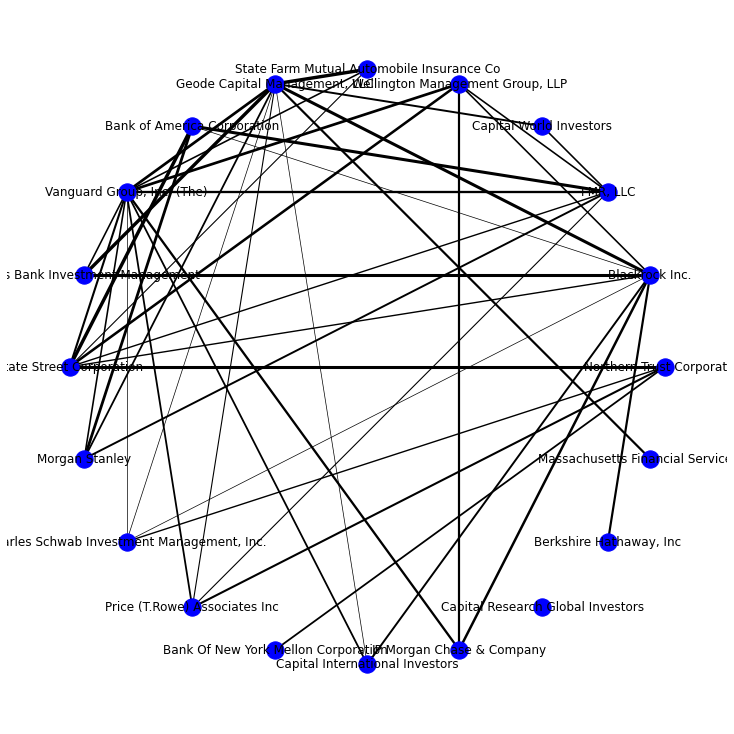

In [38]:
H_trim = trim_edges(H, weight=math.exp(1.5))

plt.figure(figsize=(10,10))
nx.draw_circular(H_trim,width=weights, node_color='blue', with_labels=True)

## Conclusion